In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

# Load the dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)

# Get the train and test splits
train_dataset = dataset['train']
test_dataset = dataset['test']


# Define image size and batch size
IMG_SIZE = 224
BATCH_SIZE = 32

def format_example(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

# Prepare the train and test datasets
train_dataset = train_dataset.map(format_example)
test_dataset = test_dataset.map(format_example)


dataset_size = info.splits['train'].num_examples

# Shuffle the dataset
train_dataset = train_dataset.shuffle(dataset_size)

# Split the dataset
val_size = int(0.2 * dataset_size)  # 20% for validation
train_size = dataset_size - val_size

# Create the train and validation datasets
val_dataset = train_dataset.take(val_size)
train_dataset = train_dataset.skip(val_size)

# Batch and prefetch datasets
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


# # Debugging: Check the sizes of the datasets
# print(f"Train size: {train_size}")
# print(f"Validation size: {val_size}")
# print(f"Number of batches in train dataset: {len(list(train_dataset))}")
# print(f"Number of batches in validation dataset: {len(list(val_dataset))}")
# print(f"Number of batches in test dataset: {len(list(test_dataset))}")

# Get the number of classes
num_classes = info.features['label'].num_classes


In [ ]:
from tensorflow.keras.applications import InceptionV3, MobileNetV2, ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def create_model(base_model, num_classes):
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

def freeze_layers(model, base_model):
    for layer in base_model.layers:
        layer.trainable = False

def compile_and_train(model, train_dataset, val_dataset, epochs=10):
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    return history

def evaluate_model(model, test_dataset):
    loss, accuracy = model.evaluate(test_dataset)
    return accuracy




In [ ]:
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_inception = create_model(base_model_inception, num_classes)

freeze_layers(model_inception, base_model_inception)
history_inception = compile_and_train(model_inception, train_dataset, val_dataset)

accuracy_inception = evaluate_model(model_inception, test_dataset)
print(f'InceptionV3 Accuracy: {accuracy_inception * 100:.2f}%')


NameError: name 'InceptionV3' is not defined

In [ ]:
base_model_mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_mobilenet = create_model(base_model_mobilenet, num_classes)

freeze_layers(model_mobilenet, base_model_mobilenet)
history_mobilenet = compile_and_train(model_mobilenet, train_dataset, val_dataset)

accuracy_mobilenet = evaluate_model(model_mobilenet, test_dataset)
print(f'MobileNetV2 Accuracy: {accuracy_mobilenet * 100:.2f}%')


9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
92/92 [==============================] - 28s 150ms/step - loss: 0.8323 - accuracy: 0.7565 - val_loss: 0.2672 - val_accuracy: 0.9185
Epoch 2/10
92/92 [==============================] - 24s 160ms/step - loss: 0.2501 - accuracy: 0.9188 - val_loss: 0.1601 - val_accuracy: 0.9511
Epoch 3/10
92/92 [==============================] - 23s 150ms/step - loss: 0.1245 - accuracy: 0.9548 - val_loss: 0.0865 - val_accuracy: 0.9715
Epoch 4/10
92/92 [==============================] - 22s 158ms/step - loss: 0.0931 - accuracy: 0.9688 - val_loss: 0.0660 - val_accuracy: 0.9823
Epoch 5/10
92/92 [==============================] - 21s 139ms/step - loss: 0.0455 - accuracy: 0.9871 - val_loss: 0.0284 - val_accuracy: 0.9905
Epoch 6/10
92/92 [==============================] - 24s 158ms/step - loss: 0.0280 - accuracy: 0.9922 - val_loss: 0.0160 - val_accuracy: 0.9973
Epoch 7/10
92/92 [==============================] - 24s 157ms/step - loss: 0.01

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def compile_and_train(model, train_dataset, val_dataset, initial_epochs=10, fine_tune_epochs=10):
    # Initial training
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

    history_initial = model.fit(train_dataset,
                                epochs=initial_epochs,
                                validation_data=val_dataset,
                                callbacks=[early_stopping, reduce_lr])

    # Unfreeze some layers and continue training with a lower learning rate
    freeze_layers_R50(model, base_model_resnet, num_layers_to_unfreeze=10)
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history_fine_tune = model.fit(train_dataset,
                                  epochs=fine_tune_epochs,
                                  validation_data=val_dataset,
                                  callbacks=[early_stopping, reduce_lr])

    return history_initial, history_fine_tune

    return history
def freeze_layers_R50(model, base_model, num_layers_to_unfreeze=0):
    for layer in base_model.layers[:-num_layers_to_unfreeze]:
        layer.trainable = False
    for layer in base_model.layers[-num_layers_to_unfreeze:]:
        layer.trainable = True
    return model
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
model_resnet = create_model(base_model_resnet, num_classes)
model_resnet = freeze_layers_R50(model_resnet, base_model_resnet, num_layers_to_unfreeze=0)
history_initial, history_fine_tune = compile_and_train(model_resnet, train_dataset, val_dataset, initial_epochs=10, fine_tune_epochs=10)
accuracy_resnet = evaluate_model(model_resnet, test_dataset)
print(f'ResNet50 Accuracy: {accuracy_resnet * 100:.2f}%')

Epoch 1/10
92/92 [==============================] - 93s 466ms/step - loss: 2.5236 - accuracy: 0.3016 - val_loss: 59.9351 - val_accuracy: 0.0285 - lr: 0.0010
Epoch 2/10
92/92 [==============================] - 52s 461ms/step - loss: 1.4950 - accuracy: 0.5370 - val_loss: 53.8542 - val_accuracy: 0.0177 - lr: 0.0010
Epoch 3/10
92/92 [==============================] - ETA: 0s - loss: 1.0255 - accuracy: 0.6685

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load and preprocess the dataset
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize images to 224x224
    image = image / 255.0  # Normalize images to [0, 1] range
    return image, label

# Data augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, label

train_dataset = train_dataset.map(preprocess_image).map(augment).cache()
test_dataset = test_dataset.map(preprocess_image).cache()

# Define the split ratio
val_size = 0.2  # 20% for validation
total_train = info.splits['train'].num_examples
val_samples = int(total_train * val_size)

# Shuffle the dataset before splitting
train_dataset = train_dataset.shuffle(buffer_size=total_train)

# Create validation and training datasets
val_dataset = train_dataset.take(val_samples)
train_dataset = train_dataset.skip(val_samples)

# Batch and prefetch the datasets
batch_size = 32
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

# Define the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze the last few layers for fine-tuning
for layer in base_model.layers[-10:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(37, activation='softmax')(x)  # 37 classes in the Oxford-IIIT Pet dataset

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model for more epochs
history = model.fit(train_dataset, epochs=2, validation_data=val_dataset)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy:.2f}')


Epoch 1/2
48/92 [==============>...............] - ETA: 1:26 - loss: 2.4569 - accuracy: 0.3704

1/1 [==============================] - 0s 37ms/step


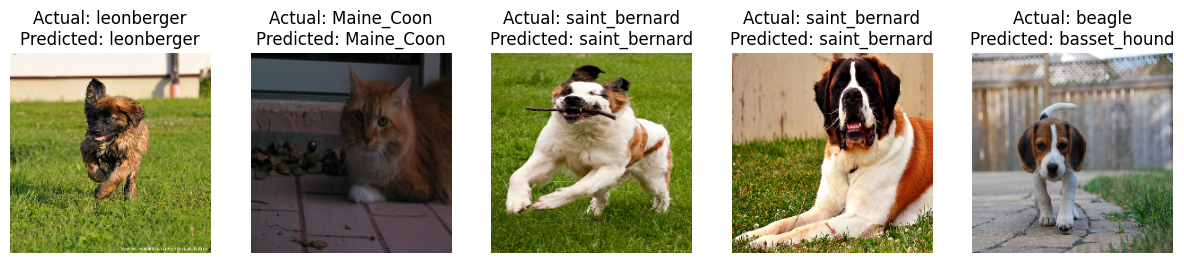

1/1 [==============================] - 0s 62ms/step


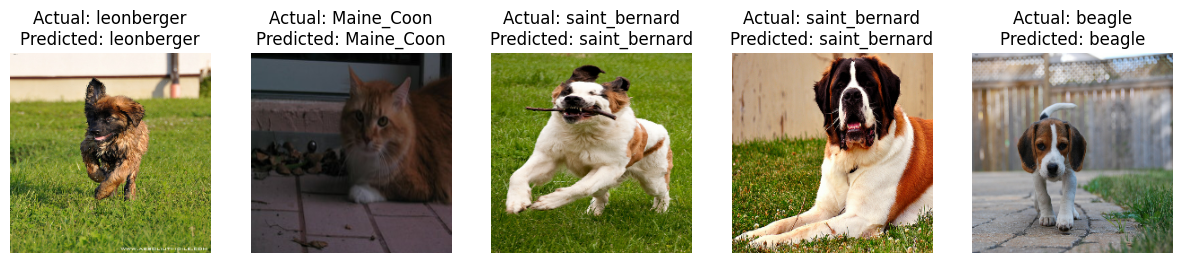

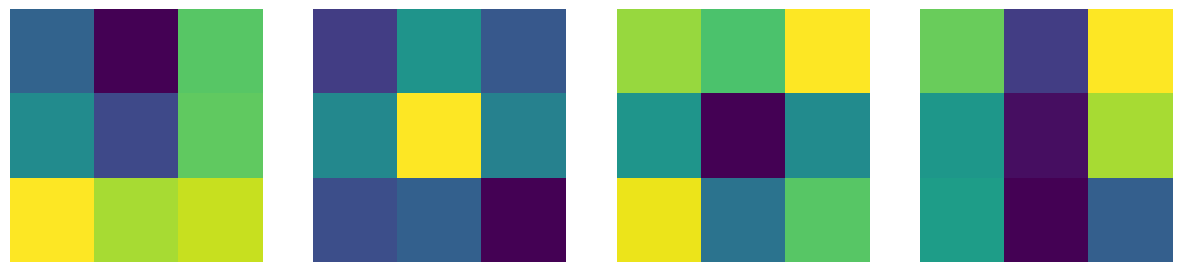

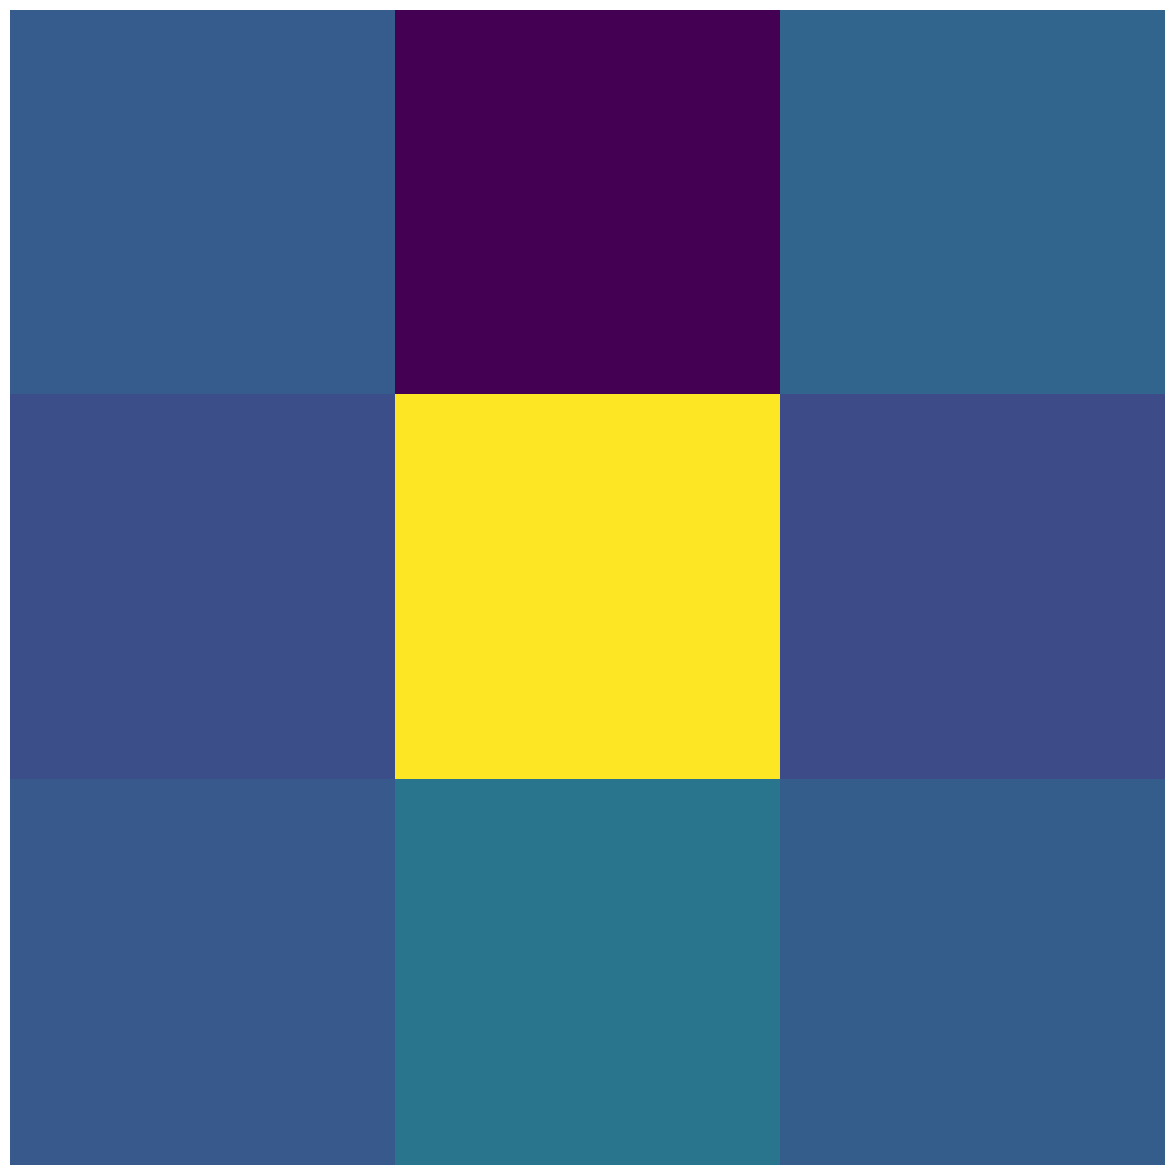

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model, dataset, class_names, num_images=5):
    for images, labels in dataset.take(1):
        predictions = model.predict(images)
        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Actual: {class_names[labels[i]]}\nPredicted: {class_names[np.argmax(predictions[i])]}")
            plt.axis("off")
        plt.show()

class_names = info.features['label'].names
plot_predictions(model_inception, test_dataset, class_names)
plot_predictions(model_mobilenet, test_dataset, class_names)
# plot_predictions(model_resnet, test_dataset, class_names)

def plot_conv_weights(model, layer_name, num_filters=4):
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    weights = layer.get_weights()[0]  # Get only the filter weights
    n_filters = min(weights.shape[3], num_filters)
    plt.figure(figsize=(15, 15))
    for i in range(n_filters):
        f = weights[:, :, :, i]
        plt.subplot(1, n_filters, i + 1)
        plt.imshow(f[:, :, 0], cmap='viridis')
        plt.axis('off')
    plt.show()

# Find convolutional layer names
conv_layer_names_inception = [layer.name for layer in model_inception.layers if 'conv' in layer.name]
conv_layer_names_mobilenet = [layer.name for layer in model_mobilenet.layers if 'conv' in layer.name]
# conv_layer_names_resnet = [layer.name for layer in model_resnet.layers if 'conv' in layer.name]

# Plot convolutional weights
plot_conv_weights(model_inception, conv_layer_names_inception[0], num_filters=4)
plot_conv_weights(model_mobilenet, conv_layer_names_mobilenet[0], num_filters=4)
# plot_conv_weights(model_resnet, conv_layer_names_resnet[0], num_filters=4)


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# بارگیری دیتاست
(ds_train, ds_val), ds_info = tfds.load('oxford_iiit_pet', split=['train[:80%]', 'train[80%:]'], with_info=True, as_supervised=True)

# تابع پیش‌پردازش تصاویر
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# اعمال پیش‌پردازش
AUTOTUNE = tf.data.experimental.AUTOTUNE
ds_train = ds_train.map(preprocess_image, num_parallel_calls=AUTOTUNE)
ds_val = ds_val.map(preprocess_image, num_parallel_calls=AUTOTUNE)

# آماده‌سازی دیتاست برای آموزش
BATCH_SIZE = 32
ds_train = ds_train.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# تعداد کلاس‌ها
num_classes = ds_info.features['label'].num_classes
print('num_classes', num_classes)
# بارگیری مدل ResNet50 با وزن‌های از پیش آموزش‌دیده
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# فریز کردن لایه‌های قبل از آخر
for layer in base_model.layers[:-4]:
    layer.trainable = False

# اضافه کردن لایه‌های جدید برای تطبیق با تعداد کلاس‌های دیتاست جدید
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# ایجاد مدل جدید
model = Model(inputs=base_model.input, outputs=predictions)

# کامپایل مدل
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# آموزش مدل
history = model.fit(
    ds_train,
    epochs=10,
    validation_data=ds_val
)
